## import libraries

In [4]:
#senior project (sentiment analysis on COVID tweets)
#selen,izay 2020
#import files
import numpy as np
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re


## upload data

In [6]:
data = pd.read_csv('Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [7]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [8]:
#Neutral tweets are elimineted from dataset because we only want to deal with negative and positive tweets.
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [9]:
data.head()

,text,sentiment
1,rt scottwalker didnt catch the full gopdebate ...,Positive
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive
5,rt gregabbott_tx tedcruz on my first day i wil...,Positive
6,rt warriorwoman91 i liked her and was happy wh...,Negative


In [10]:
#Show the total number of negative and positive tweets from dataset
print("positive")
print(data[ data['sentiment'] == 'Positive'].size)
print("negative")
print(data[ data['sentiment'] == 'Negative'].size)


positive
4472
negative
16986


## Preparing the embedding matrix

In [12]:
#Tokenizer is used to vectorize and convert text into Sequences so the Network can deal with it as input.

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
print((data['text'].values))
X = pad_sequences(X)

['  scottwalker didnt catch the full gopdebate last night here are some of scotts best lines in 90 seconds walker16 httptcozsff'
 '  robgeorge that carly fiorina is trending  hours after her debate  above any of the men in justcompleted gopdebate says shes on '
 '  danscavino gopdebate w realdonaldtrump delivered the highest ratings in the history of presidential debates trump2016 httptco'
 ...
 '  lrihendry tedcruz as president i will always tell the truth and do what i said i would do  gopdebates'
 '  jrehling gopdebate donald trump says that he doesnt have time for political correctness how does calling women fat pigs save him '
 '  lrihendry tedcruz headed into the presidential debates go ted \n\ngopdebates httptco8s67pz8a4a']


## LSTM Network

In [13]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


### declare the train and test dataset.

In [30]:

Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

print(X_train)
print(Y_train)

(7188, 28) (7188, 2)
(3541, 28) (3541, 2)
[[   0    0    0 ...    6    7  185]
 [   0    0    0 ...   13    2    3]
 [   0    0    0 ...  312   16  134]
 ...
 [   0    0    0 ...   41  221    2]
 [   0    0    0 ...    7 1832    2]
 [   0    0    0 ...  542  143    4]]
[[1 0]
 [0 1]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]


#### train the Network.

In [31]:
# number of epochs means how many times you go through your training set. our number of epochs is 7

batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)


Epoch 1/7
 - 7s - loss: 0.1698 - accuracy: 0.9325
Epoch 2/7
 - 7s - loss: 0.1649 - accuracy: 0.9366
Epoch 3/7
 - 7s - loss: 0.1443 - accuracy: 0.9389
Epoch 4/7
 - 7s - loss: 0.1358 - accuracy: 0.9430
Epoch 5/7
 - 7s - loss: 0.1269 - accuracy: 0.9482
Epoch 6/7
 - 7s - loss: 0.1202 - accuracy: 0.9521
Epoch 7/7
 - 7s - loss: 0.1108 - accuracy: 0.9542


In [32]:
#Extracting a validation set, and measuring score and accuracy.
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))


score: 0.69
acc: 0.83


In [17]:

#measuring the number of correct guesses.
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")



pos_acc 58.89967637540453 %
neg_acc 91.85558354324097 %


# apply model on the dataset .sentiment analysis of Tweets(1500 tweets posted on 1st June) about 'covid in China'

In [33]:
#first prapare tweets for machine to be able analyze 
df = pd.read_csv('COVID-China.csv')
df=df.dropna(axis=0,how='any')
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df['text'] = df['text'].apply(lambda x: x.replace('&amp',' '))
df['text'] = df['text'].apply(lambda x: x.replace('&amp',' '))

#df['sentiment'] = df['sentiment'].set_value)

### itarate dataset line by line and do analyse on them

In [34]:
#count each negative and positive tweets
count_negative=0
count_positive=0
checkpoint=300

for i, row in df.iterrows():
    #print(df['text'])
  
    twt=row['text']
    print(twt)

   # print(twt)
    twt = tokenizer.texts_to_sequences(twt)

    #padding the tweet to have exactly the same shape as `embedding_2` input
    twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
    
    print(twt)
    sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
     

    if(np.argmax(sentiment) == 0):
        print("negative")
        count_negative=count_negative+1
        print(count_negative)
        
    elif (np.argmax(sentiment) == 1):
        print("positive")   
        count_positive=count_positive+1
        print(count_positive)
        
   

thetalkcbs what a bunch of snowflakes whining about the covid virus being called the wuhan virus it came from wuh httpstcokhixfsvq67
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0 1378]
 [   0    0    0 ...    0    0 1162]]
negative
1
chinas inactivated covid19 vaccine is expected to finish clinical trials and get ready for the market as early as httpstcouf5fg8p5e1
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0  523]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  308]]
positive
1
coronavirus helen clark on china and covid19 httpstcobhjpsek9fk very much excellent leaders  jacinda ahdern httpstcoqm9xgvxeig
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  557]
 ...
 [   0    0  

positive
8
stfu government of china you guys be treating your people like shit and plus we still havent forgotten about you httpstcoa3wo20lnue
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0 1811]
 ...
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0    0]]
negative
16
piersmorgan i could remember vividly when job creation was booming under him you went all out praising his songs httpstco9kprwxabk5
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0  523]]
negative
17
how racist is china covid19 exposes shocking racism in china
 httpstco5nk5srpkba via youtube
[[   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  303]
 ...
 [   0    0    0 ...    0    0  311]

negative
29
realdonaldtrump its one person coming in from china we have it under control
 trump 12220

107000 us death httpstco8qfmwpeje1
[[  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   7]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 308]]
positive
19
covid probably on a plane 1st flight right now back to china saying man america wilding 
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0    0]]
positive
20
realdonaldtrump its one person coming in from china we have it under control
 trump 12220

107000 us death httpstcobxtslx0txb
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0    0]
 [   0    0  

negative
45
pti_news media narrative will shift to chidambaram and son incompetence against china and inept handling of covid httpstcohh8yipyqo2
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  213]]
negative
46
werent china the ones kicking africans out of their homes and discriminating against them during the covid situation httpstcogmgf9zyh9r
[[   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  557]
 ...
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 1135]
 [   0    0    0 ...    0    0  557]]
negative
47
a real pleasure to chair our latest widerwebinar today 

yuenyuenang on chinas response to the pandemic and imp httpstcotbunitzf6y
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  55

negative
62
mohcczim 263chat stop using faults test kits donated by china  please test  this faults covid test kits 
[[   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  355]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0    0]]
negative
63
could covid19 have been around for longer than we thought
absolutely bloody likely 
httpstco9dngmtd2jd

sent via updayuk
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  311]
 ...
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0 1439]]
positive
32
themarketswork its worse then that themarketswork

httpstcow4mtaiokys
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...  

negative
76
realdonaldtrump breaking news prime minister narendramodi and president realdonaldtrump had a telephone convers httpstcocv4j1dwu45
[[  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   7]
 ...
 [  0   0   0 ...   0   0 311]
 [  0   0   0 ...   0   0 508]
 [  0   0   0 ...   0   0 523]]
positive
41
sec pompeo is a pompous ass with the shit going on in americacovid deaths systemic racism in our law enforceme httpstco6al0kjabor
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1189]
 ...
 [   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  557]]
negative
77
httpstcor4amt49m9v fashion football and other sports gaming china covid19 breaking news and world news httpstcozlfxijhzdg
[[   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0    0    0 ...    0    0    0]
 [   0  

positive
51
independent kakra68 donald trumps america first is a scam usa import pharmaceuticals from china uk sells arm httpstcoftcwinapva
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1573]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    7]]
negative
89
10000 health workers on illness benefit and chinas first death in weeks todays covid19 main poi via httpstcoobqzvlktfn
[[   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0 1302]]
negative
90
chinas cover up of covid19 is far from the only evidence of their status as an evil empire

the latest from httpstcog1ts7q5xr7
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 .

negative
101
with boosted equity markets through may cio larry adam expects equities to be higher over the next 12 to 24 months httpstco4zyy10htcr
[[   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  557]]
negative
102
really disturbing whats happening your way usa watching your news every day please stay safe bless gfs life httpstcojdsxvyznsw
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0  303]]
positive
62
china has been caught hiding information about the coronavirus from the world health organization who which is a httpstcov27wuhqwk3
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 .

negative
112
join us ambassador to china terrybranstad to discuss recent developments and challenges in the uschina bilate httpstcomjafediqnn
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1302]]
negative
113
skynews emmabirchley ask anyone of them what the point of the protest is and what they sensibly want to achieve a httpstcoyo2u2wrcd4
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0  117]
 ...
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0  508]]
negative
114
solomonyue the richness and depth of indiaus consultations will remain an important pillar of the postcovid glo httpstcoav2i3p5bib
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 

negative
129
k0a0o0r0u0 abraham our hero 
httpstcof5rpt9l4x5
[[   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0  508]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  523]]
negative
130
duncanoldham hard to trust anything from china after their lack of transparency i do know that their reporting fo httpstcon4pxqwrtcz
[[   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0 1302]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0    0]]
positive
81
yup social media one of the biggest propaganda techniques ever used just wait til you find out obama sent covid t httpstcoffjhcce90c
[[   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1135]
 [   0    0    0 ...    0    0    0]
 [

negative
139
china is damn lucky to have idiot americans crowding the streets even in the wake of covid_19 instead of pushing c httpstco7ufuqdsool
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]]
positive
84
lmao the ccp supports your protest congratulations youre doing it wrong 

they are hardcore racists after all httpstco810lplbjwj
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0    0]]
negative
140
gajananbaddi sheetal53710240 tjose66 anilduhoon what are you seeing today destruction roting of economy migr httpstco2awbtbjyup
[[  0   0   0 ...   0   0 171]
 [  0   0   0 ...   0   0   7]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...

positive
91
maybe chinas motives have succeeded and they would stop further intrusion but they definitely wont backtrack 
fu httpstcowfpsbe05yc
[[   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0  117]
 ...
 [   0    0    0 ...    0    0  523]
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0 1189]]
negative
156
tonydsc dweberr2887 xhnews isnt true that china had vaccinated millions of people before covid outbreak

how c httpstcopyt2h3cawh
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1302]
 ...
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0  355]]
negative
157
race bait has everyone distracted anyone remember covid 19 me neither because it was overblown bullshit designed httpstcoqubiogfniz
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1189]
 

negative
172
chinas wuhan finds no new covid19 cases in citywide testing httpstcoonhdwpyxuh
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0  355]]
positive
98
1 literally 6 different black people have been killed and made national headlines in a week how could you possibl httpstcohx2yxp0t4h
[[   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  508]
 [   0    0    0 ...    0    0  355]]
negative
173
zhao lijian again the man who publicised the theory that the us army brought covid19 to china what a joker httpstcoa51gnizidl
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0    9]
 [   0    0    

positive
107
brutality in china


100000 people dying of covid


brutality towards black people
black live httpstcoekjbyizjrp
[[  0   0   0 ...   0   0 805]
 [  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0 311]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0   0]]
negative
187
the joint culprit of the global pandemic china and drtedros  led who  shame on you tedros for praising china httpstcoq6g3nkblcl
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0    0]]
negative
188
pm modi and trump the two leaders also exchanged views on other topical issues such as the covid19 situation in httpstcoyzzegbjijm
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    9]
 [   0    0    0

negative
202
oh what the heck blame president trump for italy france poland australia china covids deaths oh yeah trump httpstcozf3f8srk8u
[[   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0  755]
 [   0    0    0 ...    0    0  311]]
negative
203
benhabib6 piersmorgan reported death toll being used do you believe chinas death toll what about 3rd world cou httpstcoj9bhvxgg7e
[[   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1302]
 ...
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0 1162]
 [   0    0    0 ...    0    0    0]]
negative
204
doctor at whistleblowing wuhan hospital dies after battle with covid19 httpstco19kj3vniro
[[   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1189]
 ...
 [   0    0    0 ...    0    0    9]
 [   0

negative
218
pls share [covid update] leaked documents reveal china withheld crucial information about the coronavirus at the st httpstcomix7ukyje4
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 137]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 508]]
negative
219
rahulkanwal narendramodi realdonaldtrump they had  discussed about the following points
indias inclusion in g7 httpstcogmly3g3tmv
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0  355]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    0]]
positive
122
mollyjongfast covid19 delayed her latest programming update from china
[[   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1302]
 [   0    0    

negative
234
as the cost of coronavirus keeps piling up how can people adapt to a postlockdown world
tweet us your questions httpstcockl72razrm
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0 1511]]
negative
235
trend new yang k et al lancet oncol __clinical characteristics outcomes and risk factors for mortality in pa httpstcopceoew68jg
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  755]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  171]]
negative
236
globalisation was always the grand illusion of naive liberalism taken advantage of by illiberal and nonliberal ac httpstco4mtewtschv
[[   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1147]
 .

negative
251
hence in the situation like covid19 all multinational companies are shut down and china are launching phone at a httpstcolhqj2izu59
[[   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1302]
 ...
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0  523]
 [   0    0    0 ...    0    0 1135]]
positive
135
wuhan doctor who worked with whistleblower dies four months after contracting coronavirus china wuhan httpstcor1a2n226fg
[[   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0  355]
 ...
 [   0    0    0 ...    0    0 1378]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0  171]]
negative
252
susannematthew1 andrewscheer i would like to see trudeaus answer for this  canada covid deaths 7343     austr httpstcomnj3mshdkg
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0  137]
 ...
 [   0 

negative
259
china stalled reporting genetic information about covid19 angering who report httpstcowhzoxltbju httpstcoasmgroayfm
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0 1511]]
positive
140
breaking news prime minister narendramodi and president realdonaldtrump had a telephone conversation discussion httpstcomrzham3hkb
[[   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0  805]]
negative
260
breaking news prime minister narendramodi and president realdonaldtrump had a telephone conversation discussion httpstcojwskedxeh2
[[  0   0   0 ...   0   0 805]
 [  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0

negative
278
apfactcheck ap the who sent notice to wh in january as china told them in 123119 hence the covid19 trump sent httpstcopuuyv46yhh
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1811]
 ...
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0  355]]
negative
279
the same china where black people arent allowed to enter buildings to prevent the spread of covid19 httpstcogbe4bodut5
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  523]]
negative
280
reuters after covid hongkong  if you still believe what china saysonly god can help you

foolishness has httpstcovhtwmipggg
[[  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 311]
 ...
 [  0   0   0 ...   0   0 171]
 [  

negative
295
if china forgives africa its debt due to covid19 crisis but in exchange endcorruption and dictators stepping down
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0 1302]]
negative
296
imagine surviving covid19 and then china releases covid19 plus pro
covid_19
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0 1135]]
negative
297
crolanova read your tweets dude shabby attempt at impersonating a nonpakistani your account started on 30apr httpstcoi3u2ufshbr
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0 1147]
 ...
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0  80

 [   0    0    0 ...    0    0  171]]
negative
314
 china to stand by climate commitments despite covid19 breakout
 india becomes seventh mostaffected nation as httpstcodvwcfeze1n
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0 1302]]
negative
315
yeah fuck china they released covid on ya after trump started taxing lol httpstco2jv2ogj28r
[[  0   0   0 ...   0   0 117]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   7]
 ...
 [  0   0   0 ...   0   0 213]
 [  0   0   0 ...   0   0 755]
 [  0   0   0 ...   0   0 557]]
negative
316
who minsanterdc drtedros whoafro omsrdcongo do i think who is racist yes they hid covid19 because it origi httpstcon5aww8o8ok
[[   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 1147]
 ...
 [   0    0    0 ...    0    0  755]
 [ 

negative
336
latest us president donald trump on tuesday invited pm narendra modi to g7 summit as part of his efforts to expan httpstcoeypv1r3s4l
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0  508]
 [   0    0    0 ...    0    0    0]]
negative
337
mrbcyber ccp china communist party its all mankind covid19
[[   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0  805]
 ...
 [   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0 1135]]
negative
338
ausantileft not jet at least few weeks but what happens then china covid jihad my  to china
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0  137]
 ...
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 

negative
351
aj_axford 1cjh20 jon_mumford1982 borisjohnson there was nothing on offer then that came after when the terms o httpstcoog0evyopbd
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0 1573]]
negative
352
if lebron james leads his team to a title through

1 kobes death 
2 nba china controversy 
3 covid19
4 pol httpstcomn40skpt2c
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  213]
 [   0    0    0 ...    0    0 1189]]
negative
353
summerr_mckayy zanekanevsky_ d0wnrrrrr iameden ive seen a lot of discussion on china amp their racist ways espec httpstcokvbzeyuo3j
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0 1511]
 ...
 

negative
370
breaking news prime minister narendramodi and president realdonaldtrump had a telephone conversation discussion httpstco2lupjcskzh
[[   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  355]]
negative
371
8 now the crucial question was it easier to lockdown these 20 or so airports or the whole country
ans the airpo httpstcotz43mr1fme
[[   0    0    0 ...    0    0  755]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1302]
 ...
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    0]]
negative
372
1 where did covid 19 originate
ans china

2 how did covid 19 spread all over the world
ans through people tr httpstcozktotdtyqf
[[   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  303]
 ...

negative
387
i just saw a billboard in fullerton that masks up is a sign of respect

masks up is a sign of social control httpstcoq7kiud8keb
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  805]]
negative
388
malcolm_flex48 right joe biden handed america over to china and any other country that put his family on their pa httpstcofglgmlgaof
[[   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1811]]
negative
389
fuck me now we have tobias fucking ellwood tub thumping about china

stop the world i want to get off httpstcotwj8btwr4s
[[   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0 1189]
 ...
 [   0 

negative
400
republic we must not allow china to bully our soldiers at the border
so we must do it this time because the ent httpstcowljntwa0wo
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0 1147]]
positive
181
china held back one key bit of information for fighting covid19 report httpstcofveemdgmcj via thedailybeast
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1194]]
positive
182
a study was reported today that the full impact of the covid19 on the us economy will linger for over a decade c httpstco1ueaulm27e
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  137]
 ...
 [   0    0    0 .

negative
418
pm modi amp us president donald trump also exchanged views on other topical issues such as the covid19 situation in httpstcosp7grh5wkg
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0  171]]
negative
419
when will parliament nd state assemblies open  if you are unlocking everything during socalled unlock 10then httpstcoaor1o88btv
[[   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0    0]]
negative
420
who says 133 potential covid19 vaccines are in development according to documents posted on the organizations we httpstcomdl7yh2zl2
[[   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 1147]

negative
429
youranonnews please expose china on covid 19
[[   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  311]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0 1135]]
negative
430
i am fully convinced everything from attacking trump with lies and fake news to coronacovid to the riots occuring httpstcoyvr4j7kf7b
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0 1162]
 [   0    0    0 ...    0    0  805]]
negative
431
theresaphilips she was falsely impeaching donald trump while china was hiding covid19 shes a traitor to america
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0

negative
444
philipttirino no it appears the dems and the msm decided that covid wasnt working as well as they hoped so move httpstco4pqu8jhbwk
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0 1439]]
negative
445
tracybeanz uncoverdc stuinsd it does work in their favor if the real goal was to use the riots as a way to furth httpstcoumd0vo97qd
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0 1162]
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0 1573]]
negative
446
pm modi president trump discuss indiachina us presidency of g7 covid19 other issues
httpstcokrsk1zzaq3
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...   

negative
464
ambliuxiaoming the creation transmission and aftermath of covid19 everything is managed by china in collusion with who
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0  805]
 ...
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 1147]]
negative
465
rishimishra_ realdonaldtrump narendramodi china is probing india and diverting the worlds attentions from covi httpstcof5530h6uyz
[[  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0   9]
 [  0   0   0 ...   0   0 137]
 ...
 [  0   0   0 ...   0   0 311]
 [  0   0   0 ...   0   0 117]
 [  0   0   0 ...   0   0   0]]
positive
200
nprmichel enjoy your interviews just watched you and dan pfeiffer great job can u tell me why climate change ad httpstcokt6joiuj0f
[[   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  557]
 ...
 [   0    0    0 ...    0    0    0]
 [   0  

positive
208
realdonaldtrump thank you for everything youre doing mr president  amazing job covid race wars theyre throw httpstcoqdwjdoi0no
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1147]]
positive
209
for example it is a novel though untested argument to lay the blame of covid19 on one government and seek to su httpstcov6chr68gn1
[[   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  557]
 ...
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0  308]]
negative
480
narendramodi india has no invent policy  dst could not invent 1 original covid end techs in 60 daysjust ppe that httpstcojxobrxc1wo
[[   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0  557]
 ...

negative
496
flash indian pm modi us president donald trump speak discussed g7 india china border situation covid_19 httpstcof88ws0f3zc
[[   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0  532]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1189]]
negative
497
narendramodi realdonaldtrump as we understand from news channels your main discussion was on who and border dispu httpstco9cr5j0copk
[[   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0  557]
 ...
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1439]]
negative
498
pm modi us president donald trump speak on telephone
topics g7 indiachina border standoff who covid19

sig httpstcoodm1agn7eb
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    0]
 ...
 [   0 

negative
513
china appears to have survived covid19  will hong kong and india survive china httpstcohzrms0ufp4
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  508]]
positive
221
arrudas_orlusa wanmingyang governosp what qualifications do you have to attack china after looking at the curren httpstcok0avvex0xz
[[  0   0   0 ...   0   0   7]
 [  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0 557]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
negative
514
covid_19 entered from kerala in the south
amphancyclone from the east
china entered from ladakh in the north httpstcoc036jtzg0o
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0

negative
532
covid 19 will be leaving us very soonheaded back to europe and china  there will be no second wave  the virus httpstco9yxgtbag3b
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0  532]
 [   0    0    0 ...    0    0  805]]
positive
225
pmmodi amp us president donald trump also exchanged views on other topical issues such as the covid19 situation in httpstco0smxexbqfh
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0 1511]
 ...
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0  355]]
negative
533
idacoll11 realdonaldtrump sorry you cannot blame trump for this covid bs put blame where it belongs and thats on china
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0    7]
 ...
 [   0 

negative
551
the two leaders pm modi and prez trump also exchanged views on other topical issues such as the covid19 situati httpstcobdykbnrupn
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1302]]
negative
552
gaffneyhayden misskelseymac abc anyone can carry covid19 so banning travel only from and to china is quite xenophobic dont you think
[[   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1811]
 ...
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1439]]
negative
553
reuters do you even trust china after the virus from covid19 to unsatisfactory medi supplies from tibet httpstcozztkmvsubk
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  311]
 ...
 [

negative
560
chenweihua secpompeo everything is great but remember one thing
hongkong 
wuhanvirus 
chinaliedandpeopledied httpstcovpor4biz6v
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1378]
 [   0    0    0 ...    0    0    0]]
positive
236
gujarat ahmedabad covid19 cases rise by 279 to 12773 

httpstcoe14bzkedvb
[[   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  805]]
negative
561
acaddogent sethrogen alexaltteampete that implies a unipolar world like we had i dont see that as happening u httpstcoynv0z21kuu
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ... 

negative
575
modi expressed concern regarding the ongoing civil disturbances in the us and conveyed his best wishes for an earl httpstcosjt3gzqvts
[[   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1573]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  137]]
negative
576
india became the seventhworst hit country due to covid19 pandemic as the world health organization who covid19 httpstcobatcykyi8b
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1573]
 ...
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0  755]
 [   0    0    0 ...    0    0  805]]
negative
577
how racist is china covid19 exposes shocking racism in china httpstco3dwy7ant9l via youtube httpstcoqecgs89cac
[[   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  303]
 ...
 [   0    0   

positive
249
racism china ccp georgefloyd blacklifematters endpolicebrutality how racist is china covid19 exposes shock httpstcoaaxs51b29n
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1189]
 ...
 [   0    0    0 ...    0    0  213]
 [   0    0    0 ...    0    0 1135]
 [   0    0    0 ...    0    0 1302]]
positive
250
breaking an ap investigation finds that chinese labs delayed release of covid genome sequence for the 2 weeks betw httpstcosxnbhb4k42
[[   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0  508]
 [   0    0    0 ...    0    0  213]]
negative
593
unctad trained economist dr jitender bhandari on economic revival strategies in the era of covid19

economy httpstco28jmh3cy6a
[[   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1189]
 ...
 [

negative
608
god where is mankind headed to global population reeling under attack of covid 19 cyclone in west bengal cyclon httpstcotqhoe1w1b1
[[   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1573]
 ...
 [   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0  308]]
negative
609
drtedros is standing strongly with china if you see him closely he is standing on dead bodies of who dies with httpstcotc0dxdfbjg
[[   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  171]]
positive
257
dont ask me ask china that question okay   
covid_19 _  httpstcojyw6syxan5
[[   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1302]
 ...
 [   0    0    0 ...    0    0    7]
 [   0    0    0

negative
629
a health expert discusses how protests over the death of george floyd could cause a spike in coronavirus cases a p httpstcotgy7kgl9kx
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  355]
 ...
 [   0    0    0 ...    0    0 1135]
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0    0]]
negative
630
cclark112263 jackmjenkins vapriestess ginigerbasi forget that china knew about the virus amp covered it up for we httpstco7shmrv8ac2
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  213]]
positive
259
a health expert discusses how protests over the death of george floyd could cause a spike in coronavirus cases a p httpstcoxixxjqjpb2
[[  0   0   0 ...   0   0   7]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 355]
 ...
 [  0 

positive
267
there are  reports of chinese people being attacked around the world and many constant reports of china town in lon httpstcoyazhcleooc
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1189]]
negative
644
so the uk government should show us what plans are in place to help hong kongers learn english on arrival to help w httpstcozasf1cujrn
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0 1302]]
negative
645
china takes dog meat off restaurant menus in postcovid shift httpstcofw6o361dhv via yahoonewsuk
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...   

negative
661
michael baker senior epidemiologist and advisor to the new zealand government on how nz was able to successfully httpstcoqhaozbmy1a
[[   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1189]
 ...
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0    7]]
negative
662
she dont care about china 

un rights boss the covid19 pandemic was having a devastating impact on people of httpstcodopamgvgio
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1147]]
negative
663
looking forward to the moment when we can do this in us amp get same results no criticism intended just optimism fo httpstco7hirv2pn0k
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1147]

positive
282
but also when for the first time in history  100 journalists have been specifically targeted by antiriot police httpstcooxv6ypovgp
[[   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0    0]]
negative
676
greta realdonaldtrump people need some force to come in right track many democratic countries are not using undu httpstcopgzglb79nk
[[   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1135]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1439]]
negative
677
lopez video covid19 and chinas clandestine biological weapons program  jamie glazov productions  httpstcoim5zkwqin0
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    

negative
693
hillaryclinton in january 2020 we had the lowest employment the stock market was scoring small business were th httpstcoz7h4erbugp
[[  0   0   0 ...   0   0 355]
 [  0   0   0 ...   0   0   9]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0 311]
 [  0   0   0 ...   0   0 171]
 [  0   0   0 ...   0   0   0]]
positive
288
yost4ohio why are americans and journalists buying the communist party line about covid19 the history of lies httpstcovnfysmhaq8
[[   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  137]
 ...
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0  755]]
negative
694
im starting to see a massive influx of chinese bots ones that posted about covid propaganda are now posting pictu httpstcoiwjpyb9gbz
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  

positive
294
nigeria has taken delivery of dozens of coaches from china the countrys railway expansion agenda is proceeding httpstcottxijzvujd
[[   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0  171]
 ...
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1573]]
negative
710
eldano91633751 carletonjtysick jimwatsonottawa he means that the economic consequences of covid19 have been dev httpstco8mjfxwp6xr
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1573]
 ...
 [   0    0    0 ...    0    0 1378]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  557]]
negative
711
science and technology daily chinas commitment in global fight against covid19 

read more httpstcopifjg231vi
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 .

negative
726
yemen_conference_2020 china contribution to yemen humanitarian response is in kind related to covid19 equipment
[[   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1511]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1194]]
negative
727
realitycheck 2024 despite a still formidable task of combating covid19 at home china has been providing medica httpstcoaiottsb5gi
[[  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   7]
 ...
 [  0   0   0 ...   0   0 523]
 [  0   0   0 ...   0   0 171]
 [  0   0   0 ...   0   0   9]]
positive
302
realitycheck 1924 there is zero legal basis for holding china accountable and making it pay for covid19 essent httpstcootsxkt4qw5
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0 1429]
 [   0    0    0

negative
739
hong kong vigil for victims of 1989 tiananmen crackdown banned for the first time in 30 years covid is the reason httpstcogymixn63yn
[[   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1302]
 ...
 [   0    0    0 ...    0    0  532]
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0 1302]]
positive
312
how foreigners especially black people became unwelcome in parts of china amid covid crisis

racial tensions have httpstcolmnkemcdjo
[[   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  303]
 ...
 [   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1147]]
positive
313
skynews bbcnews bbcworld  after chinas messenger pm khans visit nepal agrees to a road and  debates a ne httpstcowjn67k9wic
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0  117]
 ...

negative
751
kyledchurch kvetchings as was subsequently pointed out in prc media many landlords accepted the waivers but refu httpstcoejzm4bphwe
[[   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0    0]]
negative
752
china crosses the lac and indias covid toll crosses chinas but still we are winning the battle online  httpstcosgftxfvpzu
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  311]]
positive
323
3rd class quality  covid    you were comparing it with china wuhan hospitals what happened httpstcortwccsgihr
[[   0    0    0 ...    0    0  532]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0 1573]
 ...
 [   0    0    0 ...    0

negative
767
siennaocontre and this is coming from the same dude who called covid the china virus what a clown
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0 1302]]
negative
768
my latest is a forecast for wpreview of the potential secondorder effects of covid19 on south asia

i argue tha httpstcoskfpc5gjrv
[[   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]]
negative
769
cnn drsanjaygupta today the americans are based on black only they are forgotten covid19 i say it in truth even httpstcorjyc7ixbzn
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1302]
 ...
 [   0    0    0 ...    0    

negative
777
opindia_com fightagainstcorona
dont trust chinese
worlds all governments should
boycott all chinese products a httpstcorgzwd67squ
[[   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0  311]]
negative
778
china_amb_india sir this will be my small humble request through you to your china govt that pls help india in c httpstcokdghpavwup
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0    0]]
positive
336
amy_siskind trump is a coward and dare not take any responsibility 
covid19 realitionship with china and this d httpstco99ylxxjpbq
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0  117]
 

positive
342
globaltimesnews spreading the covid virus is all china has done
[[   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1147]
 ...
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0    0]]
negative
794
more lines today on our bbc live page regarding covid19 

masstesting in wuhan accomplished china says

httpstcofu1fzc2cfr
[[   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  557]
 ...
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0  557]]
negative
795
thejaggi sanjay_dixit government should impose covid special import duty of certain percent on all chinese import httpstcoqp11efzrk9
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0 1

positive
347
the covid19 pandemic has seen a shift in retail habits towards ecommerce well be exploring this trend and how httpstco8q9q6prqk8
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0  755]]
negative
812
beyondthecenter 4 extreme intensification of covid19
5 hyperinflation
6 war with china
7 martial law
8 getting nuked
[[   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  117]
 ...
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1573]]
negative
813
actormanojjoshi i think not only the chinese 
phone
apps
we should boycott everything which is made by china
while httpstco9wxzzeasu4
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0   

negative
827
covid19 kidney damage

 early reports say that up to 30 of patients hospitalized with covid19 in china and new httpstcoszzfuydbw0
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0    0]]
positive
355
in the uk amp more specifically in england we have a very dense population 

we have one of the worlds major trave httpstcos3xbnmtgdi
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0    9]]
negative
828
repjasoncrow this is exactly why you must be voted out you are still worrying about a fake impeachment while the httpstcoyqc5jbxhar
[[  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0  

negative
844
report from china  hr helpdesk trends under covid19 httpstcoo0mjlboaaw
[[  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   7]
 [  0   0   0 ...   0   0   7]
 [  0   0   0 ...   0   0 303]]
positive
361
ella li and aries zhu note the changing patterns of queries on our clients employee helpdesks in our nanhai center httpstcokrmvm4yynw
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0  303]]
negative
845
the chinese city of wuhan where the novel coronavirus outbreak first emerged found no new cases of covid19 the httpstcod4jivsqgdt
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...    0    0 1573]
 [   0    0    0

negative
862
somebodys lying 100 days after peak infection wave in wuhan china tests all 10 million amp gets just 300 asymptoma httpstcoyjmqbihdfq
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1511]
 ...
 [   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0 1429]]
negative
863
no new covid sufferers 300 asymptomatic after wuhanwide tests
china does not count people who are infected with httpstco4vzw0011kf
[[   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0 1811]]
negative
864
screwedhumans covid19 and china have both been pushed out of the news cycle by the left wing radicals who are sho httpstcownjuqkilyp
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  5

negative
880
new review excerpts

  malvern college qingdao china review 19  we are in the aftermath of covid19 and thing httpstcohhffjwmue9
[[   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  303]
 ...
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1135]]
negative
881
doctors file pil ask sc to direct government to call upon china to share data on covid19 to develop an antidote httpstcooxnyshimti
[[   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1189]
 ...
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0    9]]
positive
371
usd selling looks to have priced in full recovery from covid and largely ignored china tensions could be a pivot s httpstcoke7uqzptju
[[   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1573]
 

positive
378
even before covid mncs were moving out of china due to rising wages in sectors of interest to ind workers must mo httpstcox6isrgwtic
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1189]]
negative
897
they say the best defence is offence the invisible enemy hides their hit on freedom in hongkong release a covid httpstconnmw7xuxqu
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0  311]]
negative
898
1 where did covid 19 originate
ans china

2 how did covid 19 spread all over the world
ans through people tr httpstcocrewzfzmgj
[[   0    0    0 ...    0    0  308]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  303]
 .

 [   0    0    0 ...    0    0 1189]]
negative
912
delhi cm arvindkejriwal launched the delhi corona app on tuesday to provide information on availability of beds httpstcotw4vfhycm9
[[   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0 1135]]
positive
387
coronainfoch coronavirus covid_19 uk warns china do not destroy the jewel of hong kong httpsc
httpstcoqjq57zxou2
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  557]
 ...
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0  213]]
positive
388
funky how when covid first came out america was like this is china engaging in biological warfare and now whos httpstcorelb5xutja
[[   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ..

negative
928
hundreds of positive covid19 tests not reported to ontario public health units
the people who wereare responsible httpstcojhr2e3ddt3
[[   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0  311]
 [   0    0    0 ...    0    0 1302]
 ...
 [   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  532]]
positive
394
with boosted equity markets through may cio larry adam expects equities to be higher over the next 12 to 24 months httpstco1dqq0838sq
[[   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0    0    0 ...    0    0  755]
 [   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0 1429]]
negative
929
thestalwart and its pretty evident that a majority of western countries have not been able to tackle covid like china did
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...


[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0 1811]]
positive
402
fangyao1997 thechristos1 reuters yesmaga i will vote for realdonaldtrump and hes the one potus will make httpstcox7ozw0pyfd
[[   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1302]
 ...
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0 1573]]
negative
944
two lawyers passed out incendiary devices at protests

curfew protests2020 riots2020 brickmystery httpstcoyfq2w4onll
[[   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0 1147]
 ...
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
negative
945
piersmorgan you are assuming every o

negative
962
reuters martin_shearman also secretly tells china samsung amp ministerblok engaged in a secret deal with hong ko httpstcohv3hmbuzt8
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  311]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0  755]]
positive
407
with boosted equity markets through may cio larry adam expects equities to be higher over the next 12 to 24 months httpstcoq3eurmz4qr
[[   0    0    0 ...    0    0  303]
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0    0    0 ...    0    0  508]
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0  557]]
negative
963
china restricted import of iron ore barley beef etc from australia and now stops buying soyabean amp pork from the httpstcolqzussa6ts
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0 

negative
976
press review china praises moscows timely aid to fight covid19 and turkeys foes unite  press review  tass  httpstcoqtnsnfvbyv
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 557]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0 805]
 [  0   0   0 ...   0   0 117]
 [  0   0   0 ...   0   0   0]]
negative
977
not oxford lab not us company covid solution will come from india china pharma industry httpstcokzh6iliekz via theprintindia
[[   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0    7]]
negative
978
very positive news
chinas  covid19 vaccine is expected to be ready for market by the end of 2020 or early next httpstcol6wwpo0sjw
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 557]
 ...
 [  0   0   0 ...   0   0 137]
 [  0   0   0 ...   0   0   0]


positive
422
modispeakuponchina
this is surely a conspiracy between china nepal and pakistan latter ones  the toddlers are httpstcowik5uhplrb
[[   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1573]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0  805]]
negative
993
hyder_abadii prakash14981847 voice_for_india tarekfatah because i dont thing other religions are as passive as httpstcowxwojbk7mr
[[   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0  117]
 [   0    0    0 ...    0    0 1573]
 ...
 [   0    0    0 ...    0    0 1162]
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0  557]]
positive
423
cpdrobert bigleaguepol nycmayor billdeblasio hes awake  he wants nyc to burn deblasio wants federal aid to l httpstcofxpaows1mh
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1573]
 ...
 [

negative
1006
potus realdonaldtrump notice how you forgot about coronavirus this is what you wanted you dont have covid pres httpstco8dfn8anedt
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1573]
 [   0    0    0 ...    0    0 1194]]
negative
1007
realized some acquaintances who spoke out about blacks being racist to chinese over covid saying they should be mo httpstcoedvrexjqxx
[[   0    0    0 ...    0    0  557]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    7]
 ...
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
positive
432
after 5 million years trapped in china because of covid this is finally home httpstcozs2stdsfkc
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0 1194]
 ...
 [   0    0    0 ...    0  

negative
1021
anjaanraju91 zlj517 evidence about covid19 starts from chinawe are the first country take covid19 seriously do httpstcolo2j7fzmbe
[[   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1511]
 [   0    0    0 ...    0    0  805]
 [   0    0    0 ...    0    0    0]]
negative
1022
lopez video covid19 and chinas clandestine biological weapons program httpstconhe8qostkf
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1147]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0 1439]
 [   0    0    0 ...    0    0 1811]]
negative
1023
sarahmarb if china succeeds in developing covid vaccine is it to be imported or not
[[   0    0    0 ...    0    0  137]
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ...    0    0  557]
 ...
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0 1147]
 [   0   

positive
453
in the sky  locust 
on the ground covid 19  made in china 
underground  earthquake 
in the httpstcovcjpswptl7
[[   0    0    0 ...    0    0    9]
 [   0    0    0 ...    0    0 1302]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0 1194]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 1162]]
negative
1032
few weeks ago china were targeting and discriminating against africans residing in china with regard to spreading o httpstcoasxg9qrqfb
[[   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  303]
 ...
 [   0    0    0 ...    0    0 1429]
 [   0    0    0 ...    0    0 1811]
 [   0    0    0 ...    0    0  805]]
negative
1033
china business digest exworld leaders have urged the g20 to do more to tackle the covid19 crisis as global infe httpstcowuoihd1qme
[[   0    0    0 ...    0    0 1189]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ...    0    0    9]
 ...
 [   0    0

positive tweets that was posted on 1st june in China among 1500 random tweets:
460
negative tweets that was posted on 1st june in China among 1500 random tweets:
1040


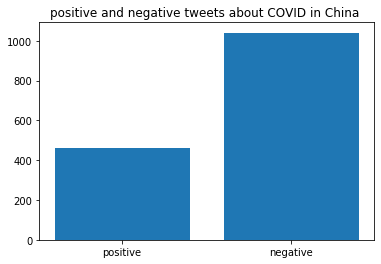

In [35]:
      
   
print("positive tweets that was posted on 1st june in China among 1500 random tweets:")
print(count_positive)
print ("negative tweets that was posted on 1st june in China among 1500 random tweets:")
print(count_negative)

import numpy as np
import matplotlib.pyplot as plt
 
# Make a fake dataset:
height = [count_positive, count_negative]
bars = ('positive', 'negative')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.title('positive and negative tweets about COVID in China ')  
# Show graphic
plt.show()

